In [5]:
import warnings, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
warnings.filterwarnings('ignore') 

import numpy as np, pandas as pd
from datetime import datetime
import time
import sys
from tensorflow.keras.callbacks import ModelCheckpoint,Callback,LearningRateScheduler, EarlyStopping, CSVLogger, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
from nbeats_model import NBeatsNet as NBeatsNet
warnings.filterwarnings(action='ignore', message='Setting attributes')
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.model_selection import KFold

from utils import TSMinMaxScaler, DailyAggregator, generate_sine_data, MinMaxScaler_Feat_Dim

# Load Data

In [6]:
data_dir = './data/'
dataset = 'energy'            # sine, stocks, energy
perc = 5                    # 5, 10, 20, 100
train_on = 'generated_data'         # 'real_data', 'generated_data'
vae_type = 'convI'

input_file = f'{dataset}_subsampled_train_perc_{perc}.npy'

data = np.load(data_dir + input_file)

N, T, D = data.shape   
print('data shape:', N, T, D) 

data shape: 913 24 28


# Some variables

In [7]:
backcast_length=20
forecast_length=4
seq_len = backcast_length + forecast_length

input_dim = output_dim = D
scaler_upper_bound = 5.
scaler_lower_bound = -5.

num_k_folds = 5

# Cross Validation Folds

In [11]:
kf = KFold(n_splits=2)

cv_data = []
for train_index, valid_index in kf.split(data):
    true_train_data, true_valid_data = data[train_index], data[valid_index]
    cv_data.append((true_train_data, true_valid_data))


(457, 24, 28)

In [13]:
cv_data[0][0].shape, cv_data[0][1].shape

((456, 24, 28), (457, 24, 28))

# Train Validation Split In Samples On True Data

In [140]:
valid_perc = 0.1

N_train = int(N * (1 - valid_perc))
N_valid = N - N_train

# Shuffle data
np.random.shuffle(data)

true_train_data = data[:N_train]
true_valid_data = data[N_train:]

print(true_train_data.shape, true_valid_data.shape )

(3129, 24, 6) (348, 24, 6)


# Read synthetic data as dataframe

In [141]:
#syn_train_data = true_train_data

In [142]:
if train_on == 'real_data':
    syn_train_data = true_train_data
else: 
    fname = f'vae_{vae_type}_generated_{dataset}_subsampled_train_perc_{perc}.npy'
    syn_train_data = np.load(data_dir + fname)
print(syn_train_data.shape)

(3129, 24, 6)


# Define model train and validation sets

In [143]:
train_data = syn_train_data
valid_data = true_valid_data

print(train_data.shape,  valid_data.shape)

(3129, 24, 6) (348, 24, 6)


# Preprocess synthetic data

### Add reversed series for training

In [144]:
train_data = np.concatenate([train_data, np.flip(train_data, axis=1)], axis=0)
train_data.shape

(6258, 24, 6)

# Min Max Scale Training and Validation Data

In [145]:
train_data_scaler = TSMinMaxScaler(
    scaling_len = backcast_length,
    input_dim = input_dim,
    upper_bound = scaler_upper_bound,
    lower_bound = scaler_lower_bound
)
scaled_train_data = train_data_scaler.fit_transform(train_data)


valid_data_scaler = TSMinMaxScaler(
    scaling_len = backcast_length,
    input_dim = input_dim,
    upper_bound = scaler_upper_bound,
    lower_bound = scaler_lower_bound
)
scaled_valid_data = valid_data_scaler.fit_transform(valid_data)

print(scaled_train_data.shape, scaled_valid_data.shape)

(6258, 24, 6) (348, 24, 6)


In [146]:
scaled_train_data.mean(), scaled_valid_data.mean()

(0.4988708558289719, 0.4865937996025106)

# X / Y Split

In [147]:
x_train, y_train = scaled_train_data[:, :backcast_length], scaled_train_data[:, backcast_length:]
x_valid, y_valid = scaled_valid_data[:, :backcast_length], scaled_valid_data[:, backcast_length:]

print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(6258, 20, 6) (6258, 4, 6) (348, 20, 6) (348, 4, 6)


In [148]:
print(x_train.mean(), y_train.mean(), x_valid.mean(), y_valid.mean())

0.4989339630560363 0.4985553196936488 0.4788657556303984 0.5252340194630717


# Nbeats

In [149]:
start = time.time() 

models = []
for d in range(D):
    
    print(f'-----------dim: {d}----------------')
    
    X, Y = x_train[:, :, d: d +1].copy(), y_train[:, :, d: d +1].copy()
    # X, Y = x_valid[:, :, d: d +1].copy(), y_valid[:, :, d: d +1].copy()

    model = NBeatsNet(
            input_dim=1,
            backcast_length=backcast_length, 
            forecast_length=forecast_length,
            stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
            nb_blocks_per_stack=3, 
            thetas_dim=(36, 36), 
            share_weights_in_stack=False,
            hidden_layer_units=50
        )

    model.compile(loss='mse', optimizer='adam')
    
    
    logpath = "./log/"
    logname = f'Log_nBeats_{dataset}_dim_{d}.txt'
    logfile = os.path.join(logpath, logname)
    csv_logger = CSVLogger(logfile, append=True)
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
    early = EarlyStopping(monitor='val_loss', mode='min', patience=10) # prevent overfitting

    mdpath = "./model/"
    mdname = f'nBeats_{dataset}_dim_{d}.h5'
    mdfile = os.path.join(mdpath, mdname)

    ckpt = ModelCheckpoint(mdfile, monitor='val_loss', verbose=1, save_best_only=True, mode='min') #save whole model
    callbacks_list = [ckpt, early, csv_logger, reduceLR]
    callbacks_list = [ckpt, early, csv_logger, reduceLR]
    

    # Train the model.
    print('Training...')

    model.fit(X, 
              Y, 
              validation_split=0.2, 
              batch_size=64, 
              shuffle=True, 
              epochs=20, 
              callbacks=callbacks_list,
              verbose = 0
             )
    
    models.append(model )

end = time.time()
train_time = np.round((end - start)/60.0, 2)
print(f"Total training time: {train_time} minutes") 

-----------dim: 0----------------
Training...

Epoch 00001: val_loss improved from inf to 0.10338, saving model to ./model\nBeats_stocks_dim_0.h5

Epoch 00002: val_loss improved from 0.10338 to 0.09402, saving model to ./model\nBeats_stocks_dim_0.h5

Epoch 00003: val_loss improved from 0.09402 to 0.09155, saving model to ./model\nBeats_stocks_dim_0.h5

Epoch 00004: val_loss did not improve from 0.09155

Epoch 00005: val_loss did not improve from 0.09155

Epoch 00006: val_loss did not improve from 0.09155

Epoch 00007: val_loss improved from 0.09155 to 0.09153, saving model to ./model\nBeats_stocks_dim_0.h5

Epoch 00008: val_loss did not improve from 0.09153

Epoch 00009: val_loss did not improve from 0.09153

Epoch 00010: val_loss did not improve from 0.09153

Epoch 00011: val_loss did not improve from 0.09153

Epoch 00012: val_loss did not improve from 0.09153

Epoch 00013: val_loss did not improve from 0.09153

Epoch 00014: val_loss did not improve from 0.09153

Epoch 00015: val_loss

# Predictions

In [150]:
preds = []

for d in range(D):
    X, Y = x_valid[:, :, d: d +1].copy(), y_valid[:, :, d: d +1].copy()

    # Predict on the testing set (forecast).
    Yhat = models[d].predict(X)
    preds.append(Yhat)


Yhat = np.concatenate(preds, axis=-1)
print("the prediction_forecast shape is:", Yhat.shape) #shape: (30, 5, 1)

X = x_valid
Y = y_valid

the prediction_forecast shape is: (348, 4, 6)


In [151]:
Y.mean(), Yhat.mean()

(0.5252340194630717, 0.5040234)

In [152]:
mse = mean_squared_error(Y.flatten(), Yhat.flatten())
mae = mean_absolute_error(Y.flatten(), Yhat.flatten())
r_sq = r2_score(Y.flatten(), Yhat.flatten())

print('mse', mse)
print('mae', mae)
print('r_sq', r_sq)

mse 0.1923255432540985
mae 0.316765921877313
r_sq 0.21993611635174637


In [153]:
perf_metrics = [ [
            dataset,
            f'vae_{vae_type}' if train_on == 'generated_data' else 'None',
            perc,
            'nbeats', 
            train_on,
            np.round(mse, 3), 
            np.round(np.sqrt(mse), 3),
            np.round(mae, 3),
            np.round(r_sq, 3),   
            datetime.now().strftime("%m/%d/%Y, %H:%M:%S"),
            np.round(train_time, 3),
             ]
]

columns=[
    'Dataset_Name',
    'Generator_Type',
    'Perc_of_train_hist_len',
    'Forecast_algo',
    'Trained_on',
    'MSE',
    'RMSE',
    'MAE',
    'R-squared',
    'Time_Ran',
    'Train_time_minutes',
]
# convert to dataframe
perf_metrics = pd.DataFrame(perf_metrics, columns=columns)  

f_name = f'Results_{dataset}_traindata_perc{perc}_nbeats_trained_on_{train_on}.csv'
perf_metrics.to_csv(f"./outputs/{f_name}", index=False)


perf_metrics

,Dataset_Name,Generator_Type,Perc_of_train_hist_len,Forecast_algo,Trained_on,MSE,RMSE,MAE,R-squared,Time_Ran,Train_time_minutes
0,stocks,vae_convI,100,nbeats,generated_data,0.192,0.439,0.317,0.22,"08/22/2021, 17:42:12",1.94


# Plot

In [154]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


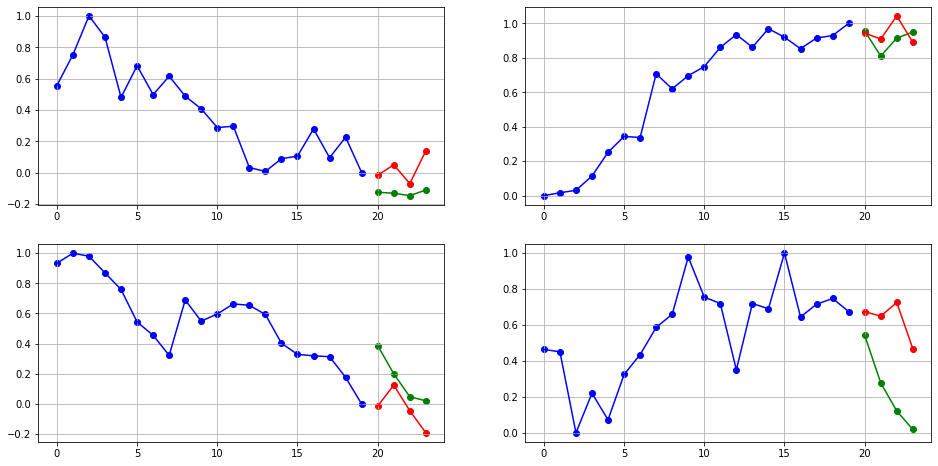

In [155]:
subplots = [221, 222, 223, 224]
plt.figure(1, figsize=(16,8))
norm_constant = 1
dim = 0

temp_y = Y.copy()
temp_yhat = Yhat.copy()
temp_x = X.copy()

for plot_id, i in enumerate(np.random.choice(range(len(X)), size=4, replace=False)):
    p1 = np.expand_dims(Yhat[i][:,dim], axis=-1)
    x1 = np.expand_dims(X[i][:,dim], axis=-1)
    y1 = np.expand_dims(Y[i][:,dim], axis=-1)
    ff, xx, yy = p1 * norm_constant, x1 * norm_constant, y1 * norm_constant
    plt.subplot(subplots[plot_id])
    plt.grid()
    plot_scatter(range(0, backcast_length), xx, color='b')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
    plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
plt.savefig("nbeats-predictions-sines.png", dpi=300)
plt.show()